In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

import json
import os
import pprint
import collections
# COCO API
from pycocotools import mask as COCOmask
from pycocotools.coco import COCO

In [2]:
category_to_id = {
    'pedestrian': 1,
}
category_instancesonly = [
    'pedestrian',
]

# Cityscapes 训练集数据分析
## 读取文件

In [3]:
root_dir = '../json_annotations'
json_name = 'citypersons_train.json'
json_file = os.path.join(root_dir, json_name)
print('读取标注文件: ', json_file)
anns = json.load(open(json_file))
print('json文件字典中的关键字: ', anns.keys())
# coco = COCO(json_file)


读取标注文件:  ../json_annotations/citypersons_train.json
json文件字典中的关键字:  [u'images', u'info', u'type', u'annotations', u'categories']


## 标注文件格式分析

In [4]:
print('annotations 中的关键字:', anns['annotations'][0].keys())
print('类别: ')
pprint.pprint(anns['categories'])
print('包含图片的数量: ', len(anns['images']))
print('包含示例的数量: ', len(anns['annotations']))

annotations 中的关键字: [u'segmentation', u'area', u'iscrowd', u'ignore', u'image_id', u'bbox', u'posv', u'category_id', u'id']
类别: 
[{u'id': 1, u'name': u'pedestrian', u'supercategory': u'pedestrian'}]
包含图片的数量:  2975
包含示例的数量:  15405


# 使用pandas转成DataFrame类型的数据格式

In [5]:
id_to_category = {}
for object_cls in anns['categories']:
    print(object_cls)
    if str(object_cls['id']) not in id_to_category:
        id_to_category[str(object_cls['id'])] = object_cls['name']
print(id_to_category)

{u'supercategory': u'pedestrian', u'id': 1, u'name': u'pedestrian'}
{'1': u'pedestrian'}


In [6]:
def map_rois_to_fpn_levels(areas, k_min=2, k_max=6):
    """Determine which FPN level each RoI in a set of RoIs should map to based
    on the heuristic in the FPN paper.
    """
    # Compute level ids
    s = np.sqrt(areas)
    s0 = 224  # default: 224
    lvl0 = 4  # default: 4

    # Eqn.(1) in FPN paper
    target_lvls = np.floor(lvl0 + np.log2(s / s0 + 1e-6))
    target_lvls = np.clip(target_lvls, k_min, k_max)
    return target_lvls

In [7]:
bboxes = np.empty((len(anns['annotations']), 9))
dic = collections.OrderedDict()
dic['category_num'] = []
dic['category'] = []
dic['x1'] = []
dic['y1'] = []
dic['w'] = []
dic['h'] = []
dic['aspect'] = []
dic['log_aspect'] = []
dic['area'] = []
dic['log_area'] = []
dic['sqrt_area'] = []
dic['target_lvls'] = []
for i in range(len(anns['annotations'])):
    bbox = anns['annotations'][i]['bbox']
    dic['category_num'].append(anns['annotations'][i]['category_id'])
    dic['category'].append(id_to_category[str(anns['annotations'][i]['category_id'])])
    dic['x1'].append(bbox[0])
    dic['y1'].append(bbox[1])
    dic['w'].append(bbox[2])
    dic['h'].append(bbox[3])
    dic['aspect'].append(float(bbox[2])/float(bbox[3]))
    dic['log_aspect']= np.log(float(bbox[2])/float(bbox[3]))
    dic['area'].append(anns['annotations'][i]['area'])
    dic['log_area'].append(np.log2(anns['annotations'][i]['area']))
    dic['sqrt_area'].append(np.sqrt(anns['annotations'][i]['area']))
    dic['target_lvls'].append(map_rois_to_fpn_levels(anns['annotations'][i]['area'], k_min=2, k_max=5))

df = pd.DataFrame(dic)

print(df.head())

   category_num    category    x1   y1   w    h    aspect  log_aspect  area  \
0             1  pedestrian  1290  425  25   61  0.409836   -0.896088  1525   
1             1  pedestrian    73  407  29   71  0.408451   -0.896088  2059   
2             1  pedestrian  1692  417  26   64  0.406250   -0.896088  1664   
3             1  pedestrian  1722  441  13   31  0.419355   -0.896088   403   
4             1  pedestrian    83  442  53  128  0.414062   -0.896088  6784   

    log_area  sqrt_area  target_lvls  
0  10.574594  39.051248          2.0  
1  11.007728  45.376205          2.0  
2  10.700440  40.792156          2.0  
3   8.654636  20.074860          2.0  
4  12.727920  82.365041          2.0  


In [8]:
df.head()

,category_num,category,x1,y1,w,h,aspect,log_aspect,area,log_area,sqrt_area,target_lvls
0,1,pedestrian,1290,425,25,61,0.409836,-0.896088,1525,10.574594,39.051248,2.0
1,1,pedestrian,73,407,29,71,0.408451,-0.896088,2059,11.007728,45.376205,2.0
2,1,pedestrian,1692,417,26,64,0.406250,-0.896088,1664,10.700440,40.792156,2.0
3,1,pedestrian,1722,441,13,31,0.419355,-0.896088,403,8.654636,20.074860,2.0
4,1,pedestrian,83,442,53,128,0.414062,-0.896088,6784,12.727920,82.365041,2.0


## 样本分布可视化

class:  pedestrian
count    15405.000000
mean        47.193054
std         40.663082
min          2.000000
25%         21.000000
50%         34.000000
75%         59.000000
max        396.000000
Name: w, dtype: float64


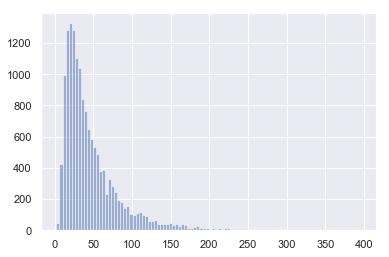

count    15405.000000
mean       115.111068
std         99.163296
min          6.000000
25%         51.000000
50%         84.000000
75%        145.000000
max        965.000000
Name: h, dtype: float64


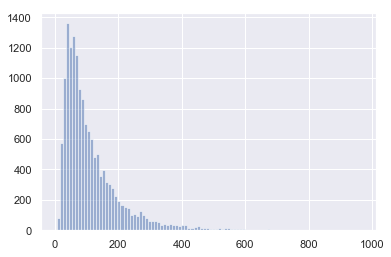

/home/tianliang/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


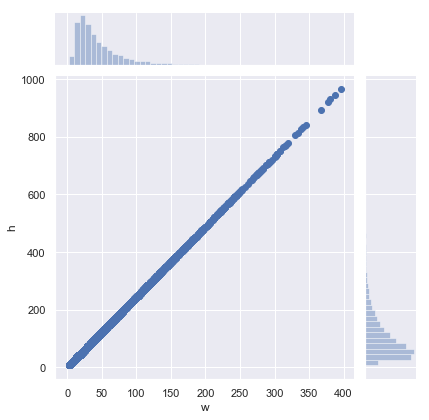

--------------------------------------------------------------------------------


In [9]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2['w'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['w'], bins=100, kde=True, rug=True);
    print(df2['w'].describe())
    plt.show()
    df2['h'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['h'], bins=100, kde=True, rug=True);
    print(df2['h'].describe())
    plt.show()
    sns.jointplot(x="w", y="h", data=df[df['category']==cls]);
    plt.show()
    print(80*'-')

# anchor的尺寸选取

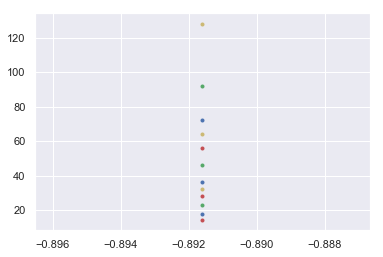

In [10]:
power = np.array([0, 1, 2])
plt.scatter(np.log(np.ones((len(power)))*0.41), 14 * 2. ** power, c='r', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 18 * 2. ** power, c='b', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 23 * 2. ** power, c='g', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 32 * 2. ** power, c='y', marker='.')
plt.show()

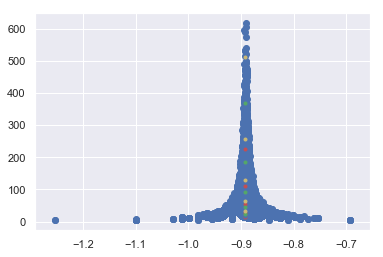

In [11]:
plt.scatter(np.log(df2['w']/df2['h']), np.sqrt(df2['w']*df2['h']))
# plt.scatter(df2['w']/df2['h'], np.sqrt(df2['w']*df2['h']))
power = np.array([0, 1, 2, 3, 4])
plt.scatter(np.log(np.ones((len(power)))*0.41), 14 * 2. ** power, c='r', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 18 * 2. ** power, c='b', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 23 * 2. ** power, c='g', marker='.')
plt.scatter(np.log(np.ones((len(power)))*0.41), 32 * 2. ** power, c='y', marker='.')
plt.show()

比较窄的那些框是因为被图片的边缘阶段了，例如下图：

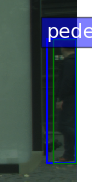

## 宽高比

class:  pedestrian
count    15405.000000
mean         0.409970
std          0.008712
min          0.285714
25%          0.406593
50%          0.410000
75%          0.413265
max          0.500000
Name: aspect, dtype: float64


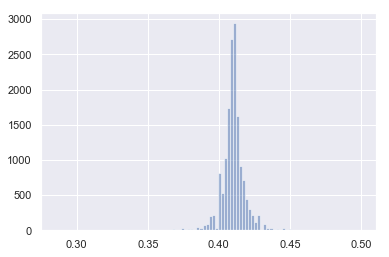

--------------------------------------------------------------------------------


In [13]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = df2['aspect']
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')

class:  pedestrian
count    15405.000000
mean        73.703688
std         63.500037
min          3.464102
25%         32.726136
50%         53.441557
75%         92.811637
max        618.174733
Name: sqrt_area, dtype: float64


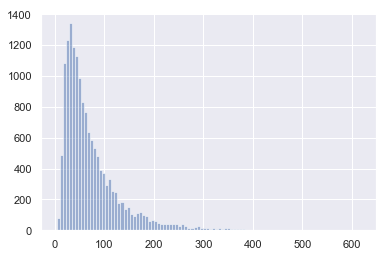

--------------------------------------------------------------------------------


In [14]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = df2['sqrt_area']
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')

## FPN目标分层分布图

class:  pedestrian
count    15405.000000
mean         2.218241
std          0.501897
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: target_lvls, dtype: float64


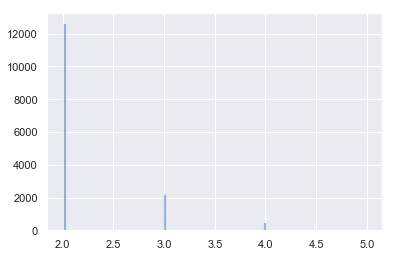

--------------------------------------------------------------------------------


In [15]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2 = df2['target_lvls']
    # df2.plot.hist(stacked=True, bins=100)
    df2.hist(color='b', alpha=0.5, bins=100)
    print(df2.describe())
    plt.show()
    print(80*'-')

In [16]:
df2.value_counts()

2.0    12639
3.0     2200
4.0      536
5.0       30
Name: target_lvls, dtype: int64

## 改进后的特征提取层分配

In [17]:
def map_rois_to_fpn_levels(areas, k_min=2, k_max=5):
    """Determine which FPN level each RoI in a set of RoIs should map to based
    on the heuristic in the FPN paper.
    """
    # Compute level ids
    s = np.sqrt(areas)
    s0 = 112 # default: 224
    lvl0 = 4  # default: 4

    # Eqn.(1) in FPN paper
    target_lvls = np.floor(lvl0 + np.log(s / s0 + 1e-6)/np.log(2))
    target_lvls = np.clip(target_lvls, k_min, k_max)
    return target_lvls

In [18]:
target_lvls2 = []
for area in dic['area']:
    target_lvls2.append(map_rois_to_fpn_levels(area, k_min=2, k_max=5))

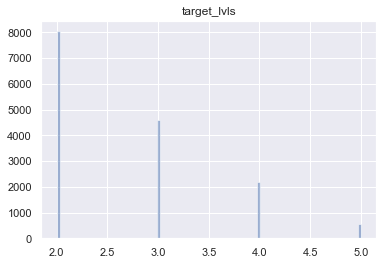

2.0    8041
3.0    4598
4.0    2200
5.0     566
Name: target_lvls, dtype: int64

In [19]:
dic_area = dict()
dic_area['target_lvls'] = target_lvls2
df_target_lvls2 = pd.DataFrame(dic_area)
df_target_lvls2.hist(color='b', alpha=0.5, bins=100)
plt.show()
df_target_lvls2['target_lvls'].value_counts()

In [21]:
out = target_lvls - np.hstack((target_lvls[1:], target_lvls[0]))
np.where(out==-1)

(array([33, 54, 88]),)

# 可见部分的框

In [42]:
bboxes = np.empty((len(anns['annotations']), 9))
dic = collections.OrderedDict()
dic['category_num'] = []
dic['category'] = []
dic['x1'] = []
dic['y1'] = []
dic['w'] = []
dic['h'] = []
dic['aspect'] = []
dic['log_aspect'] = []
dic['area'] = []
dic['log_area'] = []
for i in range(len(anns['annotations'])):
    bbox = anns['annotations'][i]['posv']
    dic['category_num'].append(anns['annotations'][i]['category_id'])
    dic['category'].append(id_to_category[str(anns['annotations'][i]['category_id'])])
    dic['x1'].append(bbox[0])
    dic['y1'].append(bbox[1])
    dic['w'].append(bbox[2])
    dic['h'].append(bbox[3])
    dic['aspect'].append(float(bbox[2])/float(bbox[3]))
    dic['log_aspect']= np.log(float(bbox[2])/float(bbox[3]))
    dic['area'].append(anns['annotations'][i]['area'])
    dic['log_area'].append(np.log(anns['annotations'][i]['area']))

df = pd.DataFrame(dic)

print(df.head())

   category_num    category    x1   y1   w    h    aspect  log_aspect  area  \
0             1  pedestrian  1292  426  22   60  0.366667   -1.167605  1525   
1             1  pedestrian    75  407  27   71  0.380282   -1.167605  2059   
2             1  pedestrian  1694  417  24   64  0.375000   -1.167605  1664   
3             1  pedestrian  1724  442  11   30  0.366667   -1.167605   403   
4             1  pedestrian    87  442  49  128  0.382812   -1.167605  6784   

   log_area  
0  7.329750  
1  7.629976  
2  7.416980  
3  5.998937  
4  8.822322  


class:  pedestrian
count    16526.000000
mean        38.168643
std         35.787594
min          1.000000
25%         16.000000
50%         26.500000
75%         48.000000
max        396.000000
Name: w, dtype: float64


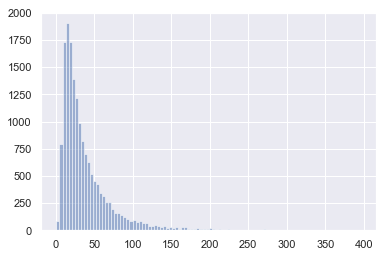

count    16526.000000
mean       101.220319
std         99.237549
min          3.000000
25%         36.000000
50%         69.000000
75%        131.000000
max        913.000000
Name: h, dtype: float64


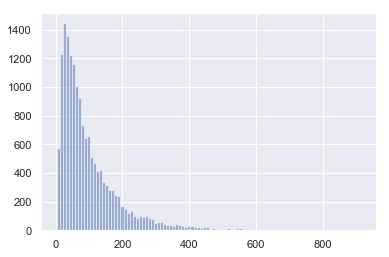

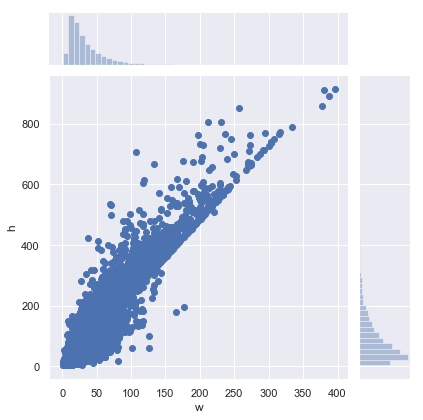

--------------------------------------------------------------------------------


In [43]:
for cls in category_instancesonly:
    print('class: ', cls)
    df2 = df[df['category']==cls]
    df2['w'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['w'], bins=100, kde=True, rug=True);
    print(df2['w'].describe())
    plt.show()
    df2['h'].hist(color='b', alpha=0.5, bins=100)
    # 使用seaborn绘制
    # sns.distplot(df2['h'], bins=100, kde=True, rug=True);
    print(df2['h'].describe())
    plt.show()
    sns.jointplot(x="w", y="h", data=df[df['category']==cls]);
    plt.show()
    print(80*'-')kuangaobi